In [11]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from imblearn.over_sampling import SMOTE


In [12]:
cwd = os.getcwd()
# Read the data
used_dataset_dir = os.path.join(cwd, 'Used_Dataset/cleaned_data')
# Read the data
train_data = pd.read_csv(os.path.join(used_dataset_dir, 'used_cleaned_data.csv'))
display(train_data.isnull().sum())
display(train_data.shape)



Date         0
Tn           0
Tx           0
Tavg         0
RH_avg       0
RR           0
ss           5
ff_x         1
ddd_x       26
ff_avg       0
ddd_car    414
rad(m)       0
dtype: int64

(1030, 12)

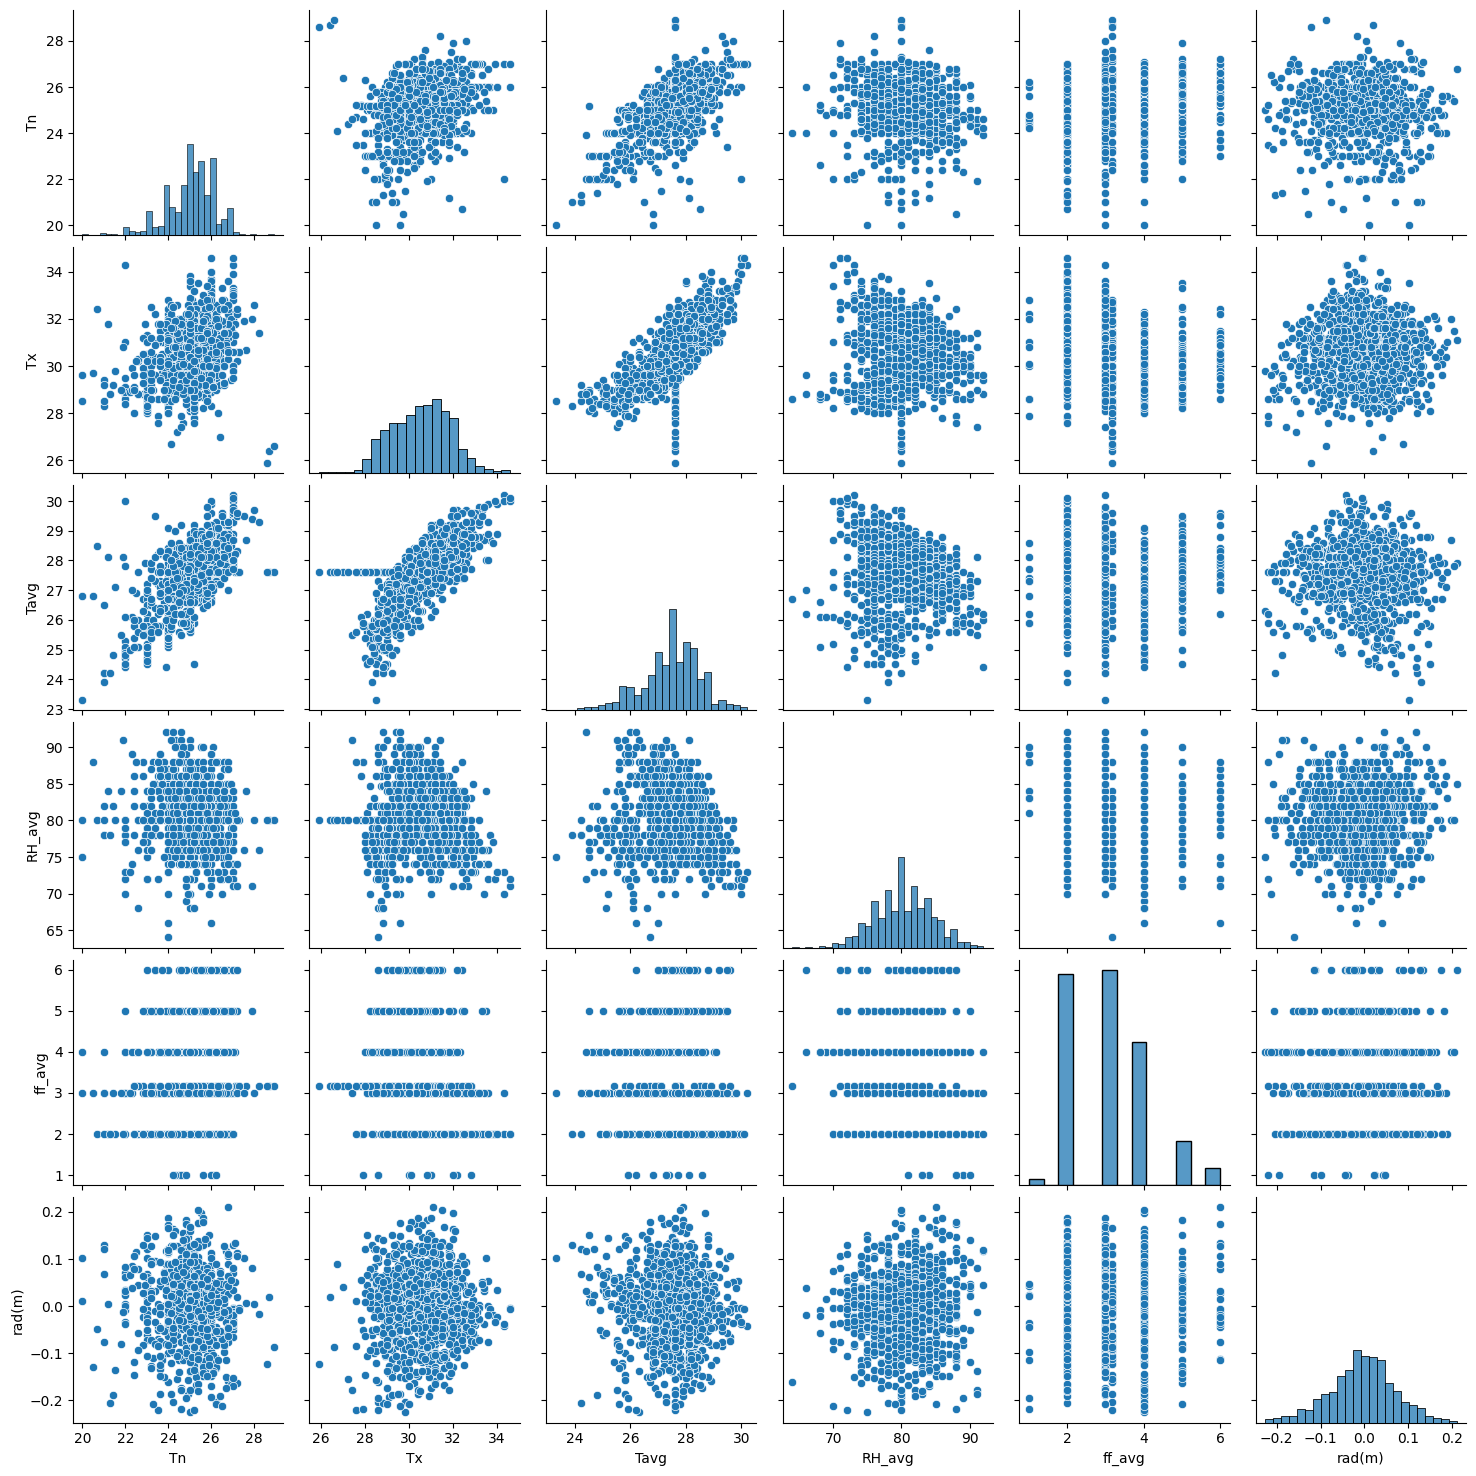

In [13]:
# Pair plot to visualize relationships between features
sns.pairplot(train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']])
plt.show()

Correlation Matrix

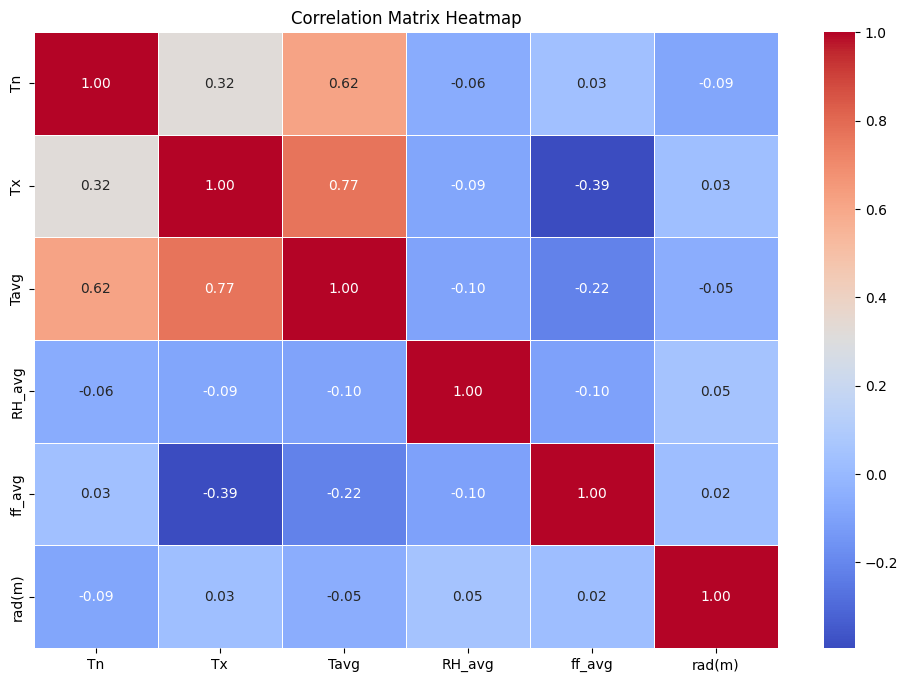

In [14]:
# Calculate the correlation matrix
correlation_matrix = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']].corr()

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title of the heatmap
plt.title('Correlation Matrix Heatmap')

# Display the heatmap
plt.show()

Linear Regression Process Start Here


In [15]:
# Custom Accuracy Metric for Regression: Predictions within a tolerance range
class RegressionAccuracy(tf.keras.metrics.Metric):
    def __init__(self, tolerance=0.05, name="regression_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.tolerance = tolerance
        self.correct_predictions = self.add_weight(name="correct_predictions", initializer="zeros")
        self.total_predictions = self.add_weight(name="total_predictions", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Compute the error between true and predicted values
        error = tf.abs(y_true - y_pred)
        
        # Check if error is within the tolerance
        within_tolerance = tf.cast(error <= self.tolerance, tf.float32)
        
        # Update the number of correct predictions and total predictions
        self.correct_predictions.assign_add(tf.reduce_sum(within_tolerance))
        self.total_predictions.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        # Return the fraction of correct predictions within tolerance
        return self.correct_predictions / self.total_predictions

    def reset_states(self):
        # Reset the metrics at the end of each epoch
        self.correct_predictions.assign(0)
        self.total_predictions.assign(0)
        
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [16]:
# Load your training data
# X = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'ss', 'ddd_x', 'RR', 'ff_x']]  # Add more features if needed
X = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg']]
y = train_data['rad(m)']
# Display the amount of training and testing data
print(f"Amount of X: {len(X)}")
print(f"Amount of y: {len(y)}")
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (Important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on training set
X_test_scaled = scaler.transform(X_test)        # Apply the transformation on test set

# Display the amount of training and testing data
print(f"Amount of X_train_scaled: {len(X_train_scaled)}")
print(f"Amount of X_test_scaled: {len(X_test_scaled)}")


# Resample data dengan mengambil sampel acak dari data pelatihanSMOTE
X_train_resampled, y_train_resampled = resample(X_train_scaled, y_train, n_samples=int(len(X_train_scaled)*2), random_state=42)
print(f"Amount of X_train after resampling: {len(X_train_resampled)}")
print(f"Amount of y_train after resampling: {len(y_train_resampled)}")


X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)
print(f"Amount of X_train after splitting: {len(X_train_resampled)}")
print(f"Amount of X_test after splitting: {len(X_test_resampled)}")



Amount of X: 1030
Amount of y: 1030
Amount of X_train_scaled: 824
Amount of X_test_scaled: 206
Amount of X_train after resampling: 1648
Amount of y_train after resampling: 1648
Amount of X_train after splitting: 1318
Amount of X_test after splitting: 330


In [17]:
# # Membangun model neural network
# model = Sequential()
# model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Layer pertama dengan 64 neuron
# model.add(Dense(32, activation='relu'))  # Layer kedua dengan 32 neuron
# model.add(Dense(1))  # Layer output (1 output karena regresi)

# # Menyusun model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', RegressionAccuracy(tolerance=0.05)])

# # Melatih model
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# results = pd.DataFrame(history.history)
# results[['loss', 'val_loss']].plot()

# # Evaluasi model
# y_pred = model.predict(X_test)


# # Evaluate the model performance
# results = model.evaluate(X_test, y_test, verbose=0)

# # Display the results
# final_loss, final_mae, final_accuracy = results

# print(f"Final Loss: {final_loss:.4f}")
# print(f"Final MAE: {final_mae:.4f}")
# print(f"Final Accuracy: {final_accuracy:.4f}")

# # Plot predictions vs actual values
# y_pred = model.predict(X_test).flatten()
# plt.plot(y_test.values, label="True")
# plt.plot(y_pred, label="Predicted")
# plt.legend()
# plt.title("Predicted vs Actual rad(m)")
# plt.show()


# # Hitung metrik evaluasi
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"R2 Score: {r2}")

Epoch 1/100


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8559 - mae: 0.6908 - regression_accuracy: 0.0982 - val_loss: 0.1179 - val_mae: 0.2760 - val_regression_accuracy: 0.2524 - learning_rate: 0.0050
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1214 - mae: 0.2584 - regression_accuracy: 0.2590 - val_loss: 0.3241 - val_mae: 0.5489 - val_regression_accuracy: 0.0049 - learning_rate: 0.0050
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0499 - mae: 0.1637 - regression_accuracy: 0.4265 - val_loss: 0.0145 - val_mae: 0.0989 - val_regression_accuracy: 0.5485 - learning_rate: 0.0050
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0212 - mae: 0.1166 - regression_accuracy: 0.5053 - val_loss: 0.0137 - val_mae: 0.0906 - val_regression_accuracy: 0.6456 - learning_rate: 0.0050
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - mae: 0.0964 - regression_accuracy: 0.6108 - val_loss: 0.0093 - val_mae: 0.0755 - val_regression_accuracy: 0.6990 -

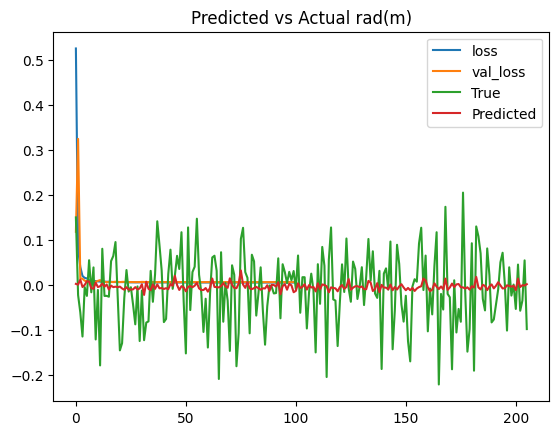

Mean Squared Error: 0.006200456020816841
R2 Score: 0.02848023892117335
Model has been saved successfully!


['Model/scaler_deep_learning_regression.pkl']

In [18]:
# Build the neural network model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # First hidden layer
    BatchNormalization(),  # Batch normalization to stabilize training
    Dropout(0.4),  # Dropout for regularization
    Dense(128, activation='relu'),  # Second hidden layer
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),  # Third hidden layer 
    Dense(1)  # Output layer for prediction
])


# Compile the model with Adam optimizer and loss function 'mse'
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae', RegressionAccuracy(tolerance=0.1)])
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)

# Train the model
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, factor=0.5)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=8, verbose=1, callbacks=[lr_scheduler])
results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()

# Evaluate the model performance
results = model.evaluate(X_test, y_test, verbose=1)

# Display the results
final_loss = results[0]
final_mae = results[1]
final_accuracy = results[2]

print(f"Final Loss: {final_loss:.4f}")
print(f"Final MAE: {final_mae:.4f}")
print(f"Final Accuracy: {final_accuracy:.4f}")

# Plot predictions vs actual values
y_pred = model.predict(X_test)
plt.plot(y_test.values, label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Predicted vs Actual rad(m)")
plt.show()


# # Hitung metrik evaluasi
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

# Save the model
model.save('Model/deep_learning_regression_model.h5')
print("Model has been saved successfully!")
# save the scaler
joblib.dump(scaler, 'Model/scaler_deep_learning_regression.pkl')

In [19]:

# Define a function for making predictions
def predict_rad(features, scaler, model):
    """
    Predict rad(m) value based on input weather features.

    Parameters:
        features (dict): A dictionary containing all feature values (Tn, Tx, Tavg, RH_avg, RR, ss, ff_x, ddd_x, ff_avg).
        scaler (StandardScaler): Scaler used to normalize the features.
        model (Sequential): Trained deep learning model.

    Returns:
        float: Predicted rad(m) value.
    """
     # Convert input features to a DataFrame with the same column names as the scaler expects
    feature_df = pd.DataFrame([features])
    
    # Scale the input features using the trained scaler
    scaled_features = scaler.transform(feature_df)

    # Predict rad(m) using the trained model
    predicted_value = model.predict(scaled_features)

    # Return the predicted rad(m) value
    return predicted_value[0][0]


In [20]:
#aman
input_features = {
    'Tn' : 22.5,      # Minimum Temperature
    'Tx' : 35.0,      # Maximum Temperature
    'Tavg' : 28.0 ,   # Average Temperature
    'RH_avg' : 75.0,  # Average Relative Humidityp
    'ff_avg' : 3.0 ,  # Average Wind Speed
}

# Call the prediction function
predicted_rad = predict_rad(input_features, scaler, model)
print(f"Predicted rad(m): {predicted_rad:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted rad(m): 0.1115
